In [6]:
import pandas as pd
import numpy as np

import re
import nltk
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser", "ner"])

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import recall_score, accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC, SVC

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from src.preprocess import clean_text, lemmatize_text

## Import pre-processed data

Write a function to import pre-processed data for modelling. Currently, just reading from a previously saved csv file.


In [7]:
# data = pd.read_csv("data/dev_data.csv")
# data['process_text'] = data['text'].apply(lambda x: clean_text(x))

# data['process_text'] = lemmatize_text(data['process_text'])

data = pd.read_csv("data/lemmatized_dev_data.csv")

emotions = data['label'].unique().tolist()
emotions.sort()
emotions

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [8]:
# split into train and test dataset. Use only 100k samples to train and use the rest as test
X_train,X_test, y_train, y_test = train_test_split(data['process_text'], data['label'], random_state=0,
                                                   train_size= int(1e5), stratify= data['label'])

### TF IDF Vectorization

In [9]:
# Create a DenseTransformer since TF-IDF vectorization returns sparse matrices
class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [16]:
res_recall = pd.DataFrame(index= emotions,
                          columns= ["multi_nb","logreg",'svc','dec_tree','rf'])
res_recall_avg = pd.DataFrame(index= ['micro', 'macro'], columns= res_recall.columns)
res_acc = pd.DataFrame(index= ['accuracy'], columns= res_recall.columns)


### Naive Bayes (Multinomial NB)

In [10]:
nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 1e-3, max_df= 0.8, stop_words= stop_words, ngram_range= (1,2))),
    ('dense', DenseTransformer()),
    ('clf', MultinomialNB())
])
nb_pipe.fit(X_train, y_train)
y_pred = nb_pipe.predict(X_test)

print(f"Naive Bayes accuracy is: {accuracy_score(y_pred, y_test):0.2f}.\n")
print(classification_report(y_test, y_pred, labels= emotions))

Naive Bayes accuracy is: 0.86.

              precision    recall  f1-score   support

       anger       0.93      0.80      0.86     32390
        fear       0.88      0.75      0.81     27463
         joy       0.81      0.97      0.88     78418
        love       0.92      0.56      0.69     18992
     sadness       0.88      0.94      0.91     67437
    surprise       0.89      0.42      0.57      8233

    accuracy                           0.86    232933
   macro avg       0.88      0.74      0.79    232933
weighted avg       0.87      0.86      0.85    232933



In [20]:
y_test_oe = pd.get_dummies(y_test).astype(int)

y_pred_oe = pd.get_dummies(y_pred).astype(int)
res_recall.loc[:,"multi_nb"] = recall_score(y_test_oe, y_pred_oe,average= None)
res_recall_avg.loc["micro", "multi_nb"] = recall_score(y_test_oe, y_pred_oe,average= 'micro')
res_recall_avg.loc["macro", "multi_nb"] = recall_score(y_test_oe, y_pred_oe,average= 'macro')

res_acc.loc["accuracy", "multi_nb"] = accuracy_score(y_test, y_pred)


### Logistic Regression

In [21]:
logreg_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 1e-3, max_df= 0.8, stop_words= stop_words, ngram_range= (1,2))),
    ('dense', DenseTransformer()),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])
logreg_pipe.fit(X_train, y_train)
y_pred = logreg_pipe.predict(X_test)

print(f"Multi-class Logistic Regression accuracy is: {accuracy_score(y_pred, y_test):0.2f}.\n")
print(classification_report(y_test, y_pred, labels= emotions))

# save decision tree grid
with open('models/tf_idf_logreg.pkl','wb') as f:
    pickle.dump(logreg_pipe,f)


Multi-class Logistic Regression accuracy is: 0.89.

              precision    recall  f1-score   support

       anger       0.91      0.85      0.88     32390
        fear       0.87      0.81      0.84     27463
         joy       0.87      0.94      0.90     78418
        love       0.83      0.76      0.79     18992
     sadness       0.92      0.93      0.93     67437
    surprise       0.80      0.73      0.76      8233

    accuracy                           0.89    232933
   macro avg       0.87      0.83      0.85    232933
weighted avg       0.89      0.89      0.89    232933



In [22]:
y_pred_oe = pd.get_dummies(y_pred).astype(int)
res_recall.loc[:,"logreg"] = recall_score(y_test_oe, y_pred_oe,average= None)
res_recall_avg.loc["micro", "logreg"] = recall_score(y_test_oe, y_pred_oe,average= 'micro')
res_recall_avg.loc["macro", "logreg"] = recall_score(y_test_oe, y_pred_oe,average= 'macro')

res_acc.loc["accuracy", "logreg"] = accuracy_score(y_test, y_pred)

In [ ]:
feature_names = logreg_pipe.named_steps['tfidf'].get_feature_names_out()

# n_max= 15
# res = pd.DataFrame(columns= emotions, index = range(0,n_max,1))

# for ii in range(0,len(emotions)):
#     res.loc[:,emotions[ii]] = pd.DataFrame(logreg_pipe.named_steps['clf'].estimators_[ii].coef_, columns= feature_names, 
#                 index= [emotions[ii]]).T.sort_values(emotions[ii], ascending= False).head(n_max).index

# res

In [24]:
# fig, axs = plt.subplots(figsize= (15,7), ncols= 3, nrows= 2);
# plt.suptitle("Top 10 features for Logistic Regression One-vs-Rest Classifier");

# color_dict = {'anger':'red', 'love': 'pink', 'sadness':'blue', 'fear':'purple', 'joy': 'coral', 'surprise':'green'}
# tmp_x_train = logreg_pipe[:-1].transform(X_train.head(10000))

# ii = jj = 0;
# for ee in range(0,len(emotions)):

#     tmp_y_train = (y_train.head(10000) == emotions[ee]).astype(int)
#     # to get permutation: 
#     results = permutation_importance(logreg_pipe[-1].estimators_[ee], tmp_x_train, tmp_y_train, scoring='recall',
#                                     n_repeats= 50, max_samples= 2500, n_jobs= 3, random_state= 0)

#     top_features = feature_names[np.argsort(np.mean(results.importances, axis= 1))][::-1][:15]
#     df_imp = pd.melt(pd.DataFrame(results.importances, index= feature_names).reindex(top_features).reset_index(), id_vars= "index")
#     df_imp.columns = ['feature','run','importance']


#     sns.boxplot(data= df_imp, x= "feature", y= "importance", order= top_features, color= color_dict[emotions[ee]], ax= axs[ii,jj])
#     axs[ii,jj].tick_params(labelrotation= 90)
#     axs[ii,jj].set_yticks([])
#     axs[ii,jj].set_ylabel('')
#     axs[ii,jj].set_xlabel('')
#     axs[ii,jj].set_title(emotions[ee])

#     jj += 1
#     if jj > 2:
#         jj = 0
#         ii += 1
    
#     del df_imp

# plt.tight_layout();
# fig.savefig("images/tfidf_feature_importance.png")

### Support Vector 
We use the SGDClassifier implementation, which is fast and does not require Bagging.
If we were to use SVC, the implementation scales quadratically with time, and in that case we would want to use BaggingClassfier.

In [28]:
svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 1e-3, max_df= 0.8, stop_words= stop_words, ngram_range= (1,2))),
    ('dense', DenseTransformer()),
    ('clf', SGDClassifier(loss= 'hinge', max_iter= 10, penalty= "l2"))
])
svc_pipe.fit(X_train, y_train)
y_pred = svc_pipe.predict(X_test)

print(f"Multi-class SVM accuracy is: {accuracy_score(y_pred, y_test):0.2f}.\n")
print(classification_report(y_test, y_pred, labels= emotions))

# save OnevsRest SVC
with open('models/tf_idf_svc.pkl','wb') as f:
    pickle.dump(svc_pipe,f)


Multi-class SVM accuracy is: 0.88.

              precision    recall  f1-score   support

       anger       0.93      0.82      0.87     32390
        fear       0.87      0.81      0.84     27463
         joy       0.85      0.96      0.90     78418
        love       0.90      0.68      0.78     18992
     sadness       0.91      0.94      0.92     67437
    surprise       0.87      0.66      0.75      8233

    accuracy                           0.88    232933
   macro avg       0.89      0.81      0.84    232933
weighted avg       0.89      0.88      0.88    232933



In [ ]:
y_pred_oe = pd.get_dummies(y_pred).astype(int)
res_recall.loc[:,"svc"] = recall_score(y_test_oe, y_pred_oe,average= None)
res_recall_avg.loc["micro", "svc"] = recall_score(y_test_oe, y_pred_oe,average= 'micro')
res_recall_avg.loc["macro", "svc"] = recall_score(y_test_oe, y_pred_oe,average= 'macro')

res_acc.loc["accuracy", "svc"] = accuracy_score(y_test, y_pred)

### Decision Tree Classifier

In [29]:
tree_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 1e-3, max_df= 0.8, stop_words= stop_words, ngram_range= (1,2))),
    ('dense', DenseTransformer()),
    ('clf', DecisionTreeClassifier(min_samples_split= 100))
])
# tree_pipe.fit(X_train.head(10000), y_train.head(10000))
# y_pred = tree_pipe.predict(X_test)

tree_grid = HalvingGridSearchCV(tree_pipe, param_grid= {'clf__min_samples_split': [0.01, 0.02, 0.05, 0.1, 0.2]}, 
                                cv= 3, verbose= 3, scoring= 'accuracy', factor= 5)
tree_grid.fit(X_train, y_train)
y_pred = tree_grid.predict(X_test)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20000
max_resources_: 100000
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 20000
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END clf__min_samples_split=0.01;, score=(train=0.887, test=0.831) total time=  50.3s
[CV 2/3] END clf__min_samples_split=0.01;, score=(train=0.890, test=0.835) total time=  47.8s
[CV 3/3] END clf__min_samples_split=0.01;, score=(train=0.885, test=0.841) total time=  46.7s
[CV 1/3] END clf__min_samples_split=0.02;, score=(train=0.881, test=0.830) total time=  49.1s
[CV 2/3] END clf__min_samples_split=0.02;, score=(train=0.878, test=0.833) total time=  45.8s
[CV 3/3] END clf__min_samples_split=0.02;, score=(train=0.880, test=0.842) total time=  46.5s
[CV 1/3] END clf__min_samples_split=0.05;, score=(train=0.878, test=0.828) total time=  48.7s
[CV 2/3] END clf__min_samples_split=0.05;, score=(train=0.877, test=0.831) to

In [ ]:
print(tree_grid.best_params_)

print(f"Multi-class Decision Tree accuracy is: {accuracy_score(y_pred, y_test):0.2f}.\n")
print(classification_report(y_test, y_pred, labels= emotions))

# save decision tree grid
with open('models/tf_idf_dec_tree.pkl','wb') as f:
    pickle.dump(tree_grid,f)

{'clf__min_samples_split': 0.2}
Multi-class Decision Tree accuracy is: 0.86.

              precision    recall  f1-score   support

       anger       0.88      0.81      0.85     32390
        fear       0.79      0.83      0.81     27463
         joy       0.83      0.92      0.87     78418
        love       0.83      0.68      0.75     18992
     sadness       0.91      0.89      0.90     67437
    surprise       0.88      0.62      0.73      8233

    accuracy                           0.86    232933
   macro avg       0.85      0.79      0.82    232933
weighted avg       0.86      0.86      0.85    232933



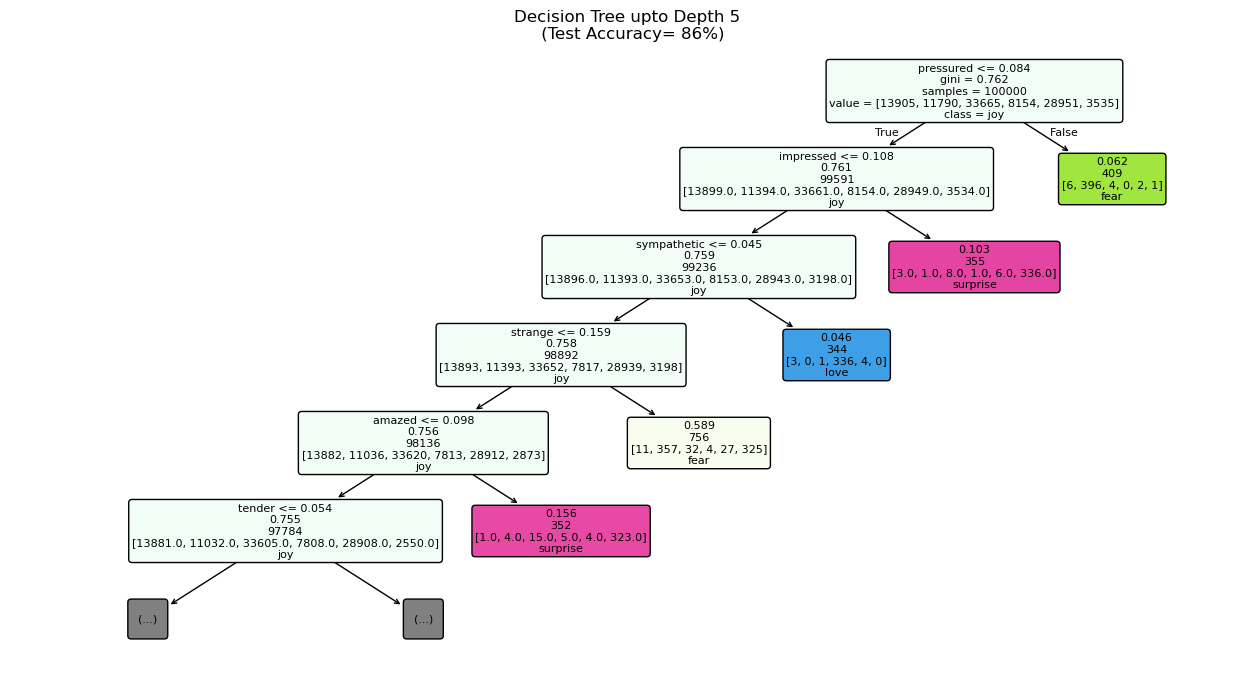

In [ ]:
fig,ax = plt.subplots(figsize= (16,8))
plot_tree(tree_grid.best_estimator_[-1], max_depth= 5, ax= ax, filled= True, feature_names= feature_names,
          class_names= emotions, rounded= True, label= 'root', impurity= True, fontsize= 8);
ax.set_title("Decision Tree upto Depth 5 \n (Test Accuracy= 86%)")
fig.savefig("images/decision_tree_depth_5.png")

In [ ]:
y_pred_oe = pd.get_dummies(y_pred).astype(int)
res_recall.loc[:,"dec_tree"] = recall_score(y_test_oe, y_pred_oe,average= None)
res_recall_avg.loc["micro", "dec_tree"] = recall_score(y_test_oe, y_pred_oe,average= 'micro')
res_recall_avg.loc["macro", "dec_tree"] = recall_score(y_test_oe, y_pred_oe,average= 'macro')

res_acc.loc["accuracy", "dec_tree"] = accuracy_score(y_test, y_pred)

#### Random Forest Classifier

In [ ]:
rf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 1e-3, max_df= 0.8, stop_words= stop_words, ngram_range= (1,2))),
    ('dense', DenseTransformer()),
    ('clf', RandomForestClassifier(n_estimators= 100, max_samples= 10000, min_samples_split= 0.02))
])
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)


print(f"Multi-class Random Forest accuracy is: {accuracy_score(y_pred, y_test):0.2f}.\n")
print(classification_report(y_test, y_pred, labels= emotions))

# save random forest classifier pipeline
with open('models/tf_idf_rf.pkl','wb') as f:
    pickle.dump(rf_pipe,f)

Multi-class Random Forest accuracy is: 0.86.

              precision    recall  f1-score   support

       anger       0.89      0.82      0.86     32390
        fear       0.83      0.81      0.82     27463
         joy       0.83      0.93      0.88     78418
        love       0.88      0.66      0.76     18992
     sadness       0.91      0.90      0.91     67437
    surprise       0.79      0.70      0.74      8233

    accuracy                           0.86    232933
   macro avg       0.86      0.80      0.83    232933
weighted avg       0.86      0.86      0.86    232933



In [ ]:
y_pred_oe = pd.get_dummies(y_pred).astype(int)
res_recall.loc[:,"rf"] = recall_score(y_test_oe, y_pred_oe,average= None)
res_recall_avg.loc["micro", "rf"] = recall_score(y_test_oe, y_pred_oe,average= 'micro')
res_recall_avg.loc["macro", "rf"] = recall_score(y_test_oe, y_pred_oe,average= 'macro')

res_acc.loc["accuracy", "rf"] = accuracy_score(y_test, y_pred)